In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import copy
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
roses = list(data_dir.glob('roses/*'))
image=cv2.imread(str(roses[3]))
image=cv2.resize(image,dsize=(64,64))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# PIL.Image.open(str(roses[1]))

array([[[ 55,  70,  64],
        [ 31,  42,  30],
        [ 38,  45,  38],
        ...,
        [155, 155, 101],
        [163, 120, 163],
        [143,  86, 125]],

       [[ 54,  63,  58],
        [ 30,  35,  27],
        [ 30,  33,  27],
        ...,
        [159, 156, 110],
        [130,  94, 104],
        [145,  87, 126]],

       [[ 39,  44,  39],
        [ 29,  32,  25],
        [ 60,  69,  62],
        ...,
        [164, 162, 109],
        [143, 137,  93],
        [138,  73, 105]],

       ...,

       [[ 98,  77,  58],
        [ 79, 101,  53],
        [ 80, 103,  46],
        ...,
        [ 94,  81,  50],
        [ 49,  59,  34],
        [ 55,  65,  34]],

       [[ 80,  89,  47],
        [ 87, 102,  50],
        [ 80, 102,  54],
        ...,
        [100,  94,  77],
        [ 68,  72,  53],
        [ 33,  44,  10]],

       [[ 76,  99,  49],
        [ 91, 103,  55],
        [ 84, 104,  67],
        ...,
        [111, 109,  52],
        [113, 108,  69],
        [ 59,  61,  34]]

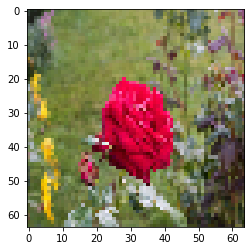

In [4]:
plt.imshow(image)
image


In [5]:
features = image.reshape((-1,3))
features = np.float32(features)

In [6]:
df_image=pd.DataFrame(features)
df_image

,0,1,2
0,55.0,70.0,64.0
1,31.0,42.0,30.0
2,38.0,45.0,38.0
3,32.0,35.0,24.0
4,40.0,52.0,28.0
...,...,...,...
4091,65.0,55.0,46.0
4092,42.0,36.0,24.0
4093,111.0,109.0,52.0
4094,113.0,108.0,69.0


In [7]:
def distance(x1, x2):
  return np.sqrt((np.square(np.array(x1) - np.array(x2))).sum())

In [8]:
def Estep(df,mu,r):
  N=df.shape[0]
  K=mu.shape[0]
  for i in range(0,N):
    xi=np.array(df.iloc[i])
    dist=np.zeros(K)
    for j in range(0,K):
      dist[j]=distance(xi,mu[j])
    cluster=np.argmin(dist,axis=0)
    r[i]=cluster
  return r  

In [9]:
def Mstep(df,mu,r):
  N=r.shape[0]
  K=mu.shape[0]
  mu_cnt=np.zeros(K)
  mu_temp=np.zeros((K,mu.shape[1]))
  for i in range(0,N):
    mu_cnt[(int)(r[i])]+=1.0
    mu_temp[(int)(r[i])]+=np.array(df.iloc[i])
  for i in range(0,K):
    mu_temp[i]=mu_temp[i]/mu_cnt[i]
  
  return mu_temp

In [10]:
def Convergence(mu1, mu2):
  K = mu1.shape[0]
  temp = np.zeros(K)
  for i in range(0, K):
      temp[i] = distance(mu1[i], mu2[i])
  return temp.sum()

In [11]:
def CostFn(df, mu, r):
    J = 0.0
    N = r.shape[0]
    for i in range(0, N):
        xi = np.array(df.iloc[i])
        dist = distance(xi, mu[(int)(r[i])])
        J += dist**2
    return J

In [12]:
def kMeans(df,K):
  N=df.shape[0]
  r=np.zeros(N)
  mu = np.zeros((K, df.shape[1]), dtype=np.float64)
  np.random.seed(1000000)
  for i in range(0, K):
      j = np.random.randint(0, N)
      mu[i] = np.array(df.iloc[j])
  delta = 0.000001
  prev_mu = np.zeros((K, df.shape[1]))
  iters = 0
  J = []
  while Convergence(prev_mu, mu) > delta:
    iters = iters+ 1
    
    r = Estep(df, mu, np.zeros(N))
    J.append(CostFn(df, mu, r))
    
    prev_mu = copy.deepcopy(mu)
    
    mu = Mstep(df, mu, r)
    J.append(CostFn(df, mu, r))
  return mu, r

In [13]:
def segmentImage(df,K):
  mu, r = kMeans(df, K)
  mu = np.uint8(mu)
  r=np.uint8(r)
  segmented_pixels = mu[r.flatten()]
  segmented_image = segmented_pixels.reshape((image.shape))
  return segmented_image

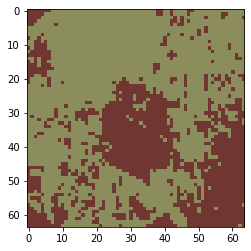

In [14]:
plt.imshow(segmentImage(df_image,2))

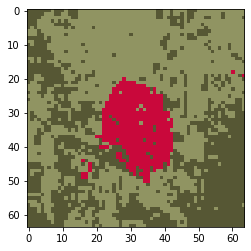

In [15]:
plt.imshow(segmentImage(df_image,3))

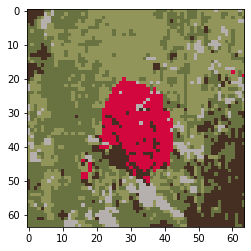

In [16]:
plt.imshow(segmentImage(df_image,5))

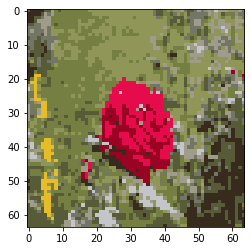

In [17]:
plt.imshow(segmentImage(df_image,10))